# Session 6: Volatility Modeling - ARCH/GARCH

## Summer School: Time Series Methods for Finance and Economics

### Learning Objectives

By the end of this session, you will be able to:
1. Understand stylized facts of financial returns
2. Test for ARCH effects in time series
3. Specify and estimate ARCH and GARCH models
4. Interpret volatility clustering and persistence
5. Generate volatility forecasts
6. Apply GARCH models to financial data
7. Understand asymmetric volatility effects
8. Implement EGARCH and GJR-GARCH models

### Prerequisites
- Sessions 4-5: ARIMA Models
- Understanding of conditional mean models
- Knowledge of Maximum Likelihood Estimation

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, EGARCH, Normal, StudentsT
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.precision', 4)

## 1. Stylized Facts of Financial Returns

### 1.1 Empirical Characteristics

Financial asset returns exhibit several robust empirical patterns:

**1. Fat Tails (Excess Kurtosis)**
- Returns have more extreme values than normal distribution
- Kurtosis > 3 (normal distribution has kurtosis = 3)
- "Black swan" events more common than Gaussian models predict

**2. Volatility Clustering**
- Large changes tend to be followed by large changes
- Small changes tend to be followed by small changes
- "Periods of calm, periods of storm"
- Strong autocorrelation in absolute/squared returns

**3. Leverage Effect**
- Negative returns associated with increased volatility
- Volatility rises more after negative shocks than positive
- Asymmetric response to news

**4. Long Memory in Volatility**
- Volatility shocks persist for long periods
- Slow decay in ACF of squared returns
- Hyperbolic rather than exponential decay

**5. No Autocorrelation in Returns**
- Returns themselves show little autocorrelation
- Weak form market efficiency
- But strong autocorrelation in volatility

### 1.2 Why ARIMA is Insufficient

ARIMA models:
- Model conditional mean only
- Assume constant variance (homoskedasticity)
- Cannot capture volatility clustering
- Underestimate risk during high volatility periods

**Need**: Models for time-varying conditional variance

In [3]:
# Download financial data
print("Downloading financial data...")

# Get multiple assets
tickers = ['^GSPC', 'BTC-USD', '^VIX']
data = yf.download(tickers, start='2020-01-01', end='2024-01-01', progress=False)['Close']
data.columns = ['SP500', 'BTC', 'VIX']
data = data.dropna()

# Calculate returns (exclude VIX from returns calculation)
returns = pd.DataFrame()
returns['SP500'] = data['SP500'].pct_change() * 100
returns['BTC'] = data['BTC'].pct_change() * 100
returns = returns.dropna()

# Keep VIX as level (it's already a volatility measure)
vix = data['VIX']

print(f"\nData period: {returns.index[0].date()} to {returns.index[-1].date()}")
print(f"Observations: {len(returns)}")
print(f"\nAssets: S&P 500, Bitcoin, VIX")

YF.download() has changed argument auto_adjust default to True

Data period: 2020-01-03 to 2023-12-29
Observations: 1005

Assets: S&P 500, Bitcoin, VIX


In [6]:
# Analyze stylized facts
def analyze_stylized_facts(returns_series, name):
    """
    Analyze and display stylized facts of financial returns.
    """
    print(f"\n{'='*60}")
    print(f"Stylized Facts Analysis: {name}")
    print(f"{'='*60}")
    
    # Descriptive statistics
    print(f"\nDescriptive Statistics:")
    print(f"  Mean: {returns_series.mean():.4f}%")
    print(f"  Std Dev: {returns_series.std():.4f}%")
    print(f"  Skewness: {returns_series.skew():.4f}")
    print(f"  Kurtosis: {returns_series.kurtosis():.4f}")
    print(f"  Min: {returns_series.min():.4f}%")
    print(f"  Max: {returns_series.max():.4f}%")
    
    # Test for normality
    jb_stat, jb_pval = stats.jarque_bera(returns_series)
    print(f"\nJarque-Bera Test (H0: Normal):")
    print(f"  Statistic: {jb_stat:.2f}")
    print(f"  P-value: {jb_pval:.4f}")
    if jb_pval < 0.05:
        print(f"  ✓ Reject normality (fat tails present)")
    
    # Autocorrelation in returns
    lb_returns = acorr_ljungbox(returns_series, lags=[10], return_df=True)
    print(f"\nLjung-Box Test on Returns (H0: No autocorrelation):")
    print(f"  Q(10): {lb_returns['lb_stat'].values[0]:.2f}")
    print(f"  P-value: {lb_returns['lb_pvalue'].values[0]:.4f}")
    
    # Autocorrelation in squared returns (volatility clustering)
    lb_squared = acorr_ljungbox(returns_series**2, lags=[10, 20], return_df=True)
    print(f"\nLjung-Box Test on Squared Returns (volatility clustering):")
    print(f"  Q(10): {lb_squared['lb_stat'].values[0]:.2f}")
    print(f"  P-value: {lb_squared['lb_pvalue'].values[0]:.4f}")
    if lb_squared['lb_pvalue'].values[0] < 0.05:
        print(f"  ✓ Strong evidence of volatility clustering")
    
    # ARCH test
    try:
        arch_test = het_arch(returns_series, nlags=10)
        print(f"\nARCH LM Test (H0: No ARCH effects):")
        print(f"  Statistic: {arch_test[0]:.2f}")
        print(f"  P-value: {arch_test[1]:.4f}")
        if arch_test[1] < 0.05:
            print(f"  ✓ ARCH effects detected → Use GARCH models")
    except:
        print(f"\nARCH test could not be computed")

# Analyze both series
analyze_stylized_facts(returns['SP500'], 'S&P 500')
analyze_stylized_facts(returns['BTC'], 'Bitcoin')


Stylized Facts Analysis: S&P 500

Descriptive Statistics:
  Mean: 0.2694%
  Std Dev: 4.2030%
  Skewness: -0.5897
  Kurtosis: 9.2055
  Min: -37.1695%
  Max: 21.1097%

Jarque-Bera Test (H0: Normal):
  Statistic: 3566.89
  P-value: 0.0000
  ✓ Reject normality (fat tails present)

Ljung-Box Test on Returns (H0: No autocorrelation):
  Q(10): 19.48
  P-value: 0.0345

Ljung-Box Test on Squared Returns (volatility clustering):
  Q(10): 37.04
  P-value: 0.0001
  ✓ Strong evidence of volatility clustering

ARCH LM Test (H0: No ARCH effects):
  Statistic: 33.27
  P-value: 0.0002
  ✓ ARCH effects detected → Use GARCH models

Stylized Facts Analysis: Bitcoin

Descriptive Statistics:
  Mean: 0.0485%
  Std Dev: 1.4497%
  Skewness: -0.4802
  Kurtosis: 11.8154
  Min: -11.9841%
  Max: 9.3828%

Jarque-Bera Test (H0: Normal):
  Statistic: 5820.60
  P-value: 0.0000
  ✓ Reject normality (fat tails present)

Ljung-Box Test on Returns (H0: No autocorrelation):
  Q(10): 225.89
  P-value: 0.0000

Ljung-Box Tes

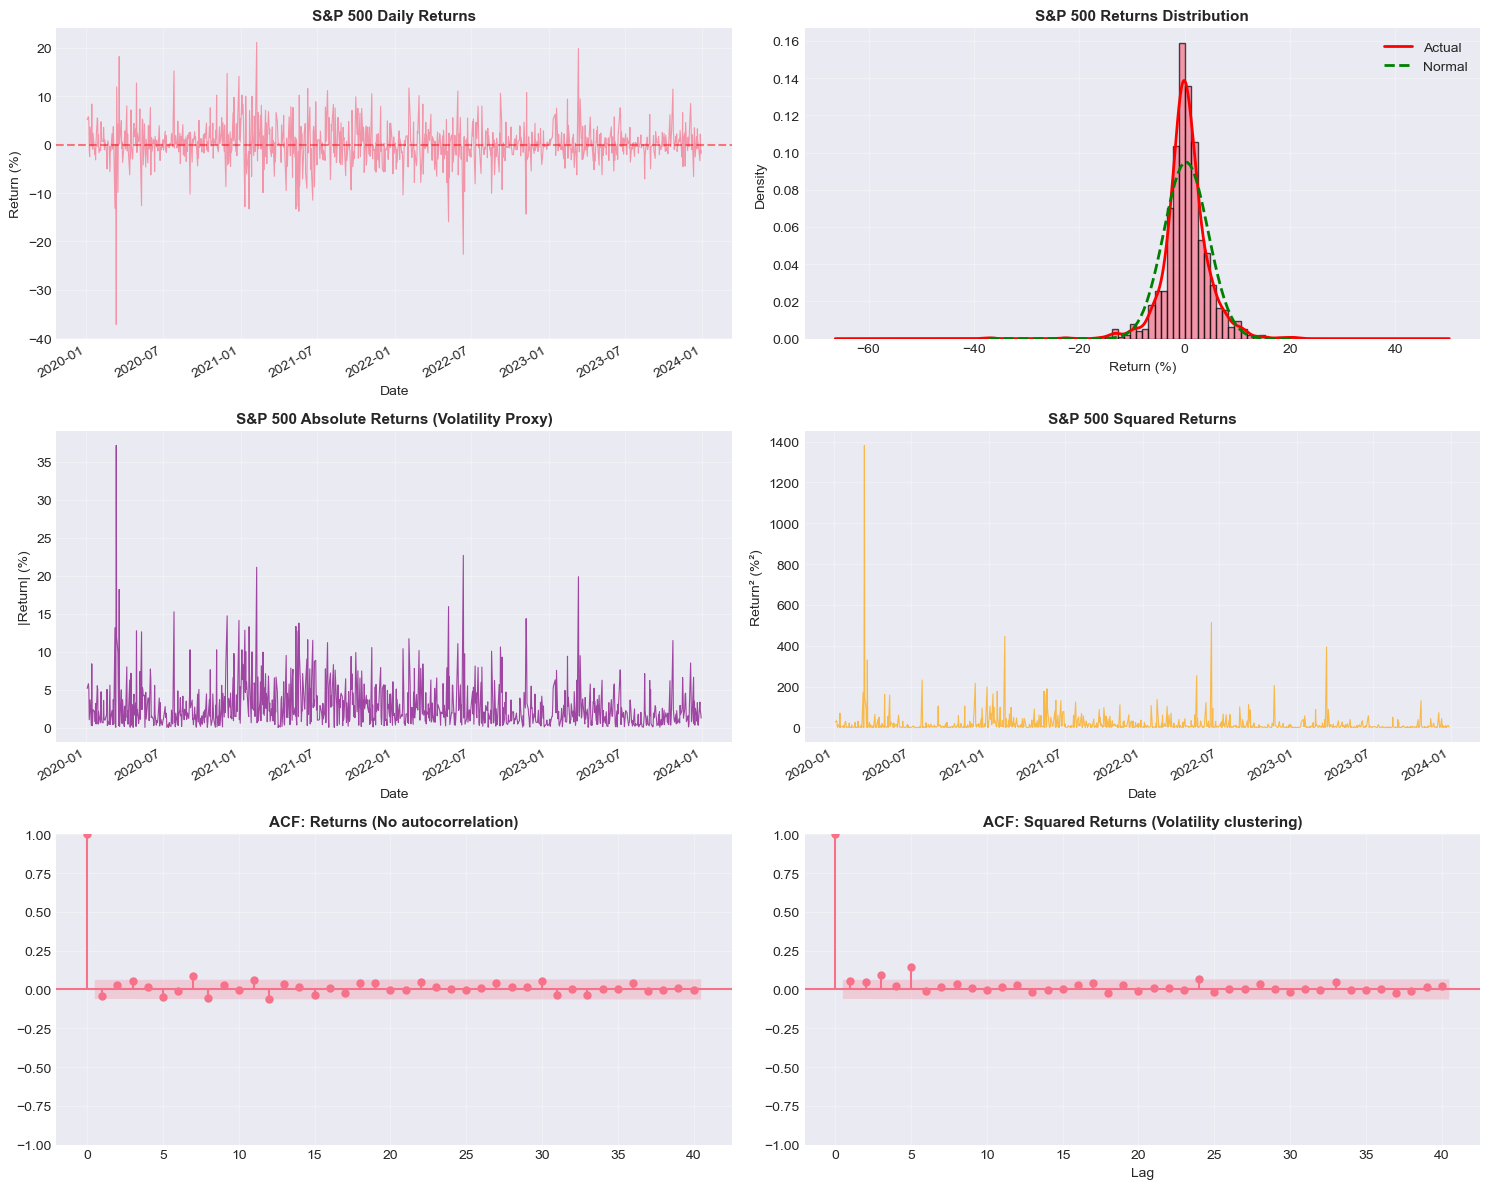


Key Observations:
• Returns show volatility clustering (periods of high/low volatility)
• Distribution has fat tails compared to normal
• Returns have little autocorrelation
• Squared returns show strong autocorrelation → ARCH effects


In [8]:
# Visualize stylized facts
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# S&P 500 Returns
returns['SP500'].plot(ax=axes[0, 0], linewidth=0.8, alpha=0.7)
axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0, 0].set_title('S&P 500 Daily Returns', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Return (%)')
axes[0, 0].grid(True, alpha=0.3)

# S&P 500 Distribution
returns['SP500'].hist(ax=axes[0, 1], bins=50, density=True, alpha=0.7, edgecolor='black')
returns['SP500'].plot.kde(ax=axes[0, 1], color='red', linewidth=2, label='Actual')
# Overlay normal distribution
x = np.linspace(returns['SP500'].min(), returns['SP500'].max(), 100)
axes[0, 1].plot(x, stats.norm.pdf(x, returns['SP500'].mean(), returns['SP500'].std()),
               'g--', linewidth=2, label='Normal')
axes[0, 1].set_title('S&P 500 Returns Distribution', fontsize=11, fontweight='bold')
axes[0, 1].set_xlabel('Return (%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Absolute returns (proxy for volatility)
abs_returns = returns['SP500'].abs()
abs_returns.plot(ax=axes[1, 0], linewidth=0.8, alpha=0.7, color='purple')
axes[1, 0].set_title('S&P 500 Absolute Returns (Volatility Proxy)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('|Return| (%)')
axes[1, 0].grid(True, alpha=0.3)

# Squared returns
squared_returns = returns['SP500'] ** 2
squared_returns.plot(ax=axes[1, 1], linewidth=0.8, alpha=0.7, color='orange')
axes[1, 1].set_title('S&P 500 Squared Returns', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Return² (%²)')
axes[1, 1].grid(True, alpha=0.3)

# ACF of returns
plot_acf(returns['SP500'], lags=40, ax=axes[2, 0], alpha=0.05)
axes[2, 0].set_title('ACF: Returns (No autocorrelation)', fontsize=11, fontweight='bold')
axes[2, 0].grid(True, alpha=0.3)

# ACF of squared returns
plot_acf(squared_returns, lags=40, ax=axes[2, 1], alpha=0.05)
axes[2, 1].set_title('ACF: Squared Returns (Volatility clustering)', fontsize=11, fontweight='bold')
axes[2, 1].set_xlabel('Lag')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("• Returns show volatility clustering (periods of high/low volatility)")
print("• Distribution has fat tails compared to normal")
print("• Returns have little autocorrelation")
print("• Squared returns show strong autocorrelation → ARCH effects")

## 2. ARCH Models

### 2.1 ARCH(q) Specification

The **Autoregressive Conditional Heteroskedasticity** model, introduced by Engle (1982):

**Mean equation**:
$$r_t = \mu + \epsilon_t$$

**Variance equation**:
$$\sigma_t^2 = \omega + \alpha_1 \epsilon_{t-1}^2 + \alpha_2 \epsilon_{t-2}^2 + \cdots + \alpha_q \epsilon_{t-q}^2$$

**Innovation**:
$$\epsilon_t = \sigma_t z_t, \quad z_t \sim N(0,1)$$

### 2.2 ARCH(1) Model

The simplest case:
$$\sigma_t^2 = \omega + \alpha_1 \epsilon_{t-1}^2$$

**Parameters**:
- $\omega > 0$: Base level of volatility
- $\alpha_1 > 0$: Volatility response to shocks

**Stationarity**: $\alpha_1 < 1$

**Unconditional variance**: $E[\epsilon_t^2] = \frac{\omega}{1-\alpha_1}$

### 2.3 Properties

**Advantages**:
- Models time-varying volatility
- Captures volatility clustering
- Fat-tailed returns

**Disadvantages**:
- May require many lags (high q)
- Non-negative constraints on parameters
- Cannot model asymmetric effects
- Superseded by GARCH in practice

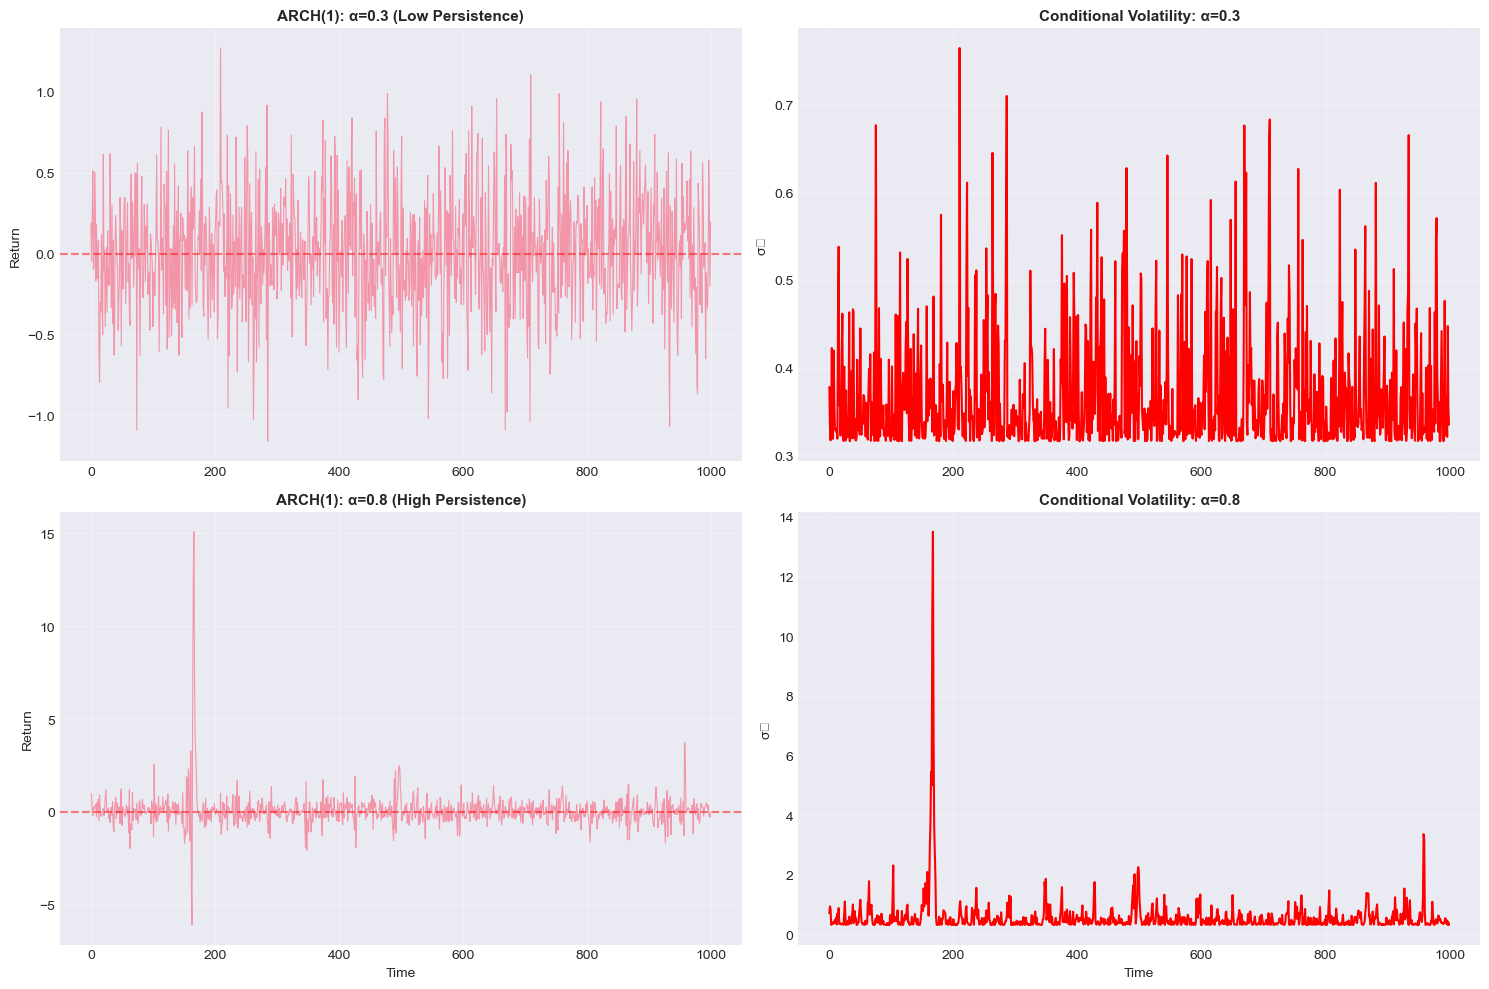


ARCH Properties:
• Higher α → More persistent volatility clustering
• Volatility responds immediately to large shocks
• Decay is exponential with rate α


In [10]:
# Simulate ARCH(1) process
def simulate_arch(n, omega, alpha, mu=0):
    """
    Simulate ARCH(1) process.
    
    Parameters:
    -----------
    n : int
        Number of observations
    omega : float
        Base variance
    alpha : float
        ARCH parameter
    mu : float
        Mean
    
    Returns:
    --------
    r : np.array
        Returns
    sigma2 : np.array
        Conditional variance
    """
    r = np.zeros(n)
    sigma2 = np.zeros(n)
    
    # Initialize
    sigma2[0] = omega / (1 - alpha)
    z = np.random.normal(0, 1, n)
    r[0] = mu + np.sqrt(sigma2[0]) * z[0]
    
    for t in range(1, n):
        sigma2[t] = omega + alpha * (r[t-1] - mu)**2
        r[t] = mu + np.sqrt(sigma2[t]) * z[t]
    
    return r, sigma2

# Simulate ARCH(1) processes with different parameters
n = 1000
r_low, sigma2_low = simulate_arch(n, omega=0.1, alpha=0.3)
r_high, sigma2_high = simulate_arch(n, omega=0.1, alpha=0.8)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Low persistence
axes[0, 0].plot(r_low, linewidth=0.8, alpha=0.7)
axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0, 0].set_title('ARCH(1): α=0.3 (Low Persistence)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Return')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(np.sqrt(sigma2_low), linewidth=1.5, color='red')
axes[0, 1].set_title('Conditional Volatility: α=0.3', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('σₜ')
axes[0, 1].grid(True, alpha=0.3)

# High persistence
axes[1, 0].plot(r_high, linewidth=0.8, alpha=0.7)
axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1, 0].set_title('ARCH(1): α=0.8 (High Persistence)', fontsize=11, fontweight='bold')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Return')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(np.sqrt(sigma2_high), linewidth=1.5, color='red')
axes[1, 1].set_title('Conditional Volatility: α=0.8', fontsize=11, fontweight='bold')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('σₜ')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nARCH Properties:")
print("• Higher α → More persistent volatility clustering")
print("• Volatility responds immediately to large shocks")
print("• Decay is exponential with rate α")

## 3. GARCH Models

### 3.1 GARCH(p,q) Specification

The **Generalized ARCH** model by Bollerslev (1986) extends ARCH:

**Variance equation**:
$$\sigma_t^2 = \omega + \sum_{i=1}^q \alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2$$

**GARCH(1,1)** - Most common specification:
$$\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$

### 3.2 Interpretation

- $\omega$: Base level (long-run variance)
- $\alpha$: News coefficient (reaction to market shocks)
- $\beta$: Persistence coefficient (memory)
- $\alpha + \beta$: Total persistence

**Constraints**:
- $\omega > 0$
- $\alpha, \beta \geq 0$
- $\alpha + \beta < 1$ (stationarity)

### 3.3 Unconditional Variance

$$E[\epsilon_t^2] = \frac{\omega}{1 - \alpha - \beta}$$

### 3.4 Why GARCH(1,1) Works

**Advantages over ARCH**:
- More parsimonious (fewer parameters)
- Can model high persistence with just 3 parameters
- ARCH(q) can be approximated by GARCH(1,1)
- Empirically performs very well

**Typical values**:
- $\alpha \approx 0.05 - 0.15$ (news impact)
- $\beta \approx 0.80 - 0.95$ (persistence)
- $\alpha + \beta \approx 0.95 - 0.99$ (high persistence)

In [12]:
# Fit GARCH(1,1) to S&P 500 returns
print("\n" + "="*60)
print("Fitting GARCH(1,1) Model to S&P 500 Returns")
print("="*60)

# Prepare data
sp_returns = returns['SP500'].dropna()

# Fit GARCH(1,1) with constant mean
garch_model = arch_model(sp_returns, vol='Garch', p=1, q=1, dist='normal')
garch_fitted = garch_model.fit(disp='off')

print(garch_fitted.summary())


Fitting GARCH(1,1) Model to S&P 500 Returns
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  SP500   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2829.58
Distribution:                  Normal   AIC:                           5667.17
Method:            Maximum Likelihood   BIC:                           5686.82
                                        No. Observations:                 1005
Date:                Mon, Jan 19 2026   Df Residuals:                     1004
Time:                        11:58:10   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.30

In [13]:
# Extract and analyze results
omega = garch_fitted.params['omega']
alpha = garch_fitted.params['alpha[1]']
beta = garch_fitted.params['beta[1]']

persistence = alpha + beta
uncond_var = omega / (1 - persistence)
uncond_vol = np.sqrt(uncond_var)

print("\n" + "="*60)
print("GARCH(1,1) Parameter Interpretation")
print("="*60)

print(f"\nEstimated Parameters:")
print(f"  ω (omega): {omega:.6f}")
print(f"  α (alpha): {alpha:.4f}")
print(f"  β (beta):  {beta:.4f}")

print(f"\nDerived Quantities:")
print(f"  Persistence (α + β): {persistence:.4f}")
print(f"  Unconditional variance: {uncond_var:.4f}")
print(f"  Unconditional volatility: {uncond_vol:.4f}%")

print(f"\nInterpretation:")
print(f"  • News impact (α): {alpha:.1%} of shock affects volatility")
print(f"  • Persistence (β): {beta:.1%} of volatility persists")
print(f"  • Total persistence: {persistence:.1%}")
print(f"  • Half-life of shocks: {np.log(0.5)/np.log(persistence):.1f} days")

if persistence > 0.99:
    print(f"  ⚠ Very high persistence → Close to unit root in variance")
elif persistence > 0.95:
    print(f"  ✓ High persistence → Typical for financial returns")


GARCH(1,1) Parameter Interpretation

Estimated Parameters:
  ω (omega): 1.354454
  α (alpha): 0.1105
  β (beta):  0.8221

Derived Quantities:
  Persistence (α + β): 0.9325
  Unconditional variance: 20.0753
  Unconditional volatility: 4.4806%

Interpretation:
  • News impact (α): 11.0% of shock affects volatility
  • Persistence (β): 82.2% of volatility persists
  • Total persistence: 93.3%
  • Half-life of shocks: 9.9 days


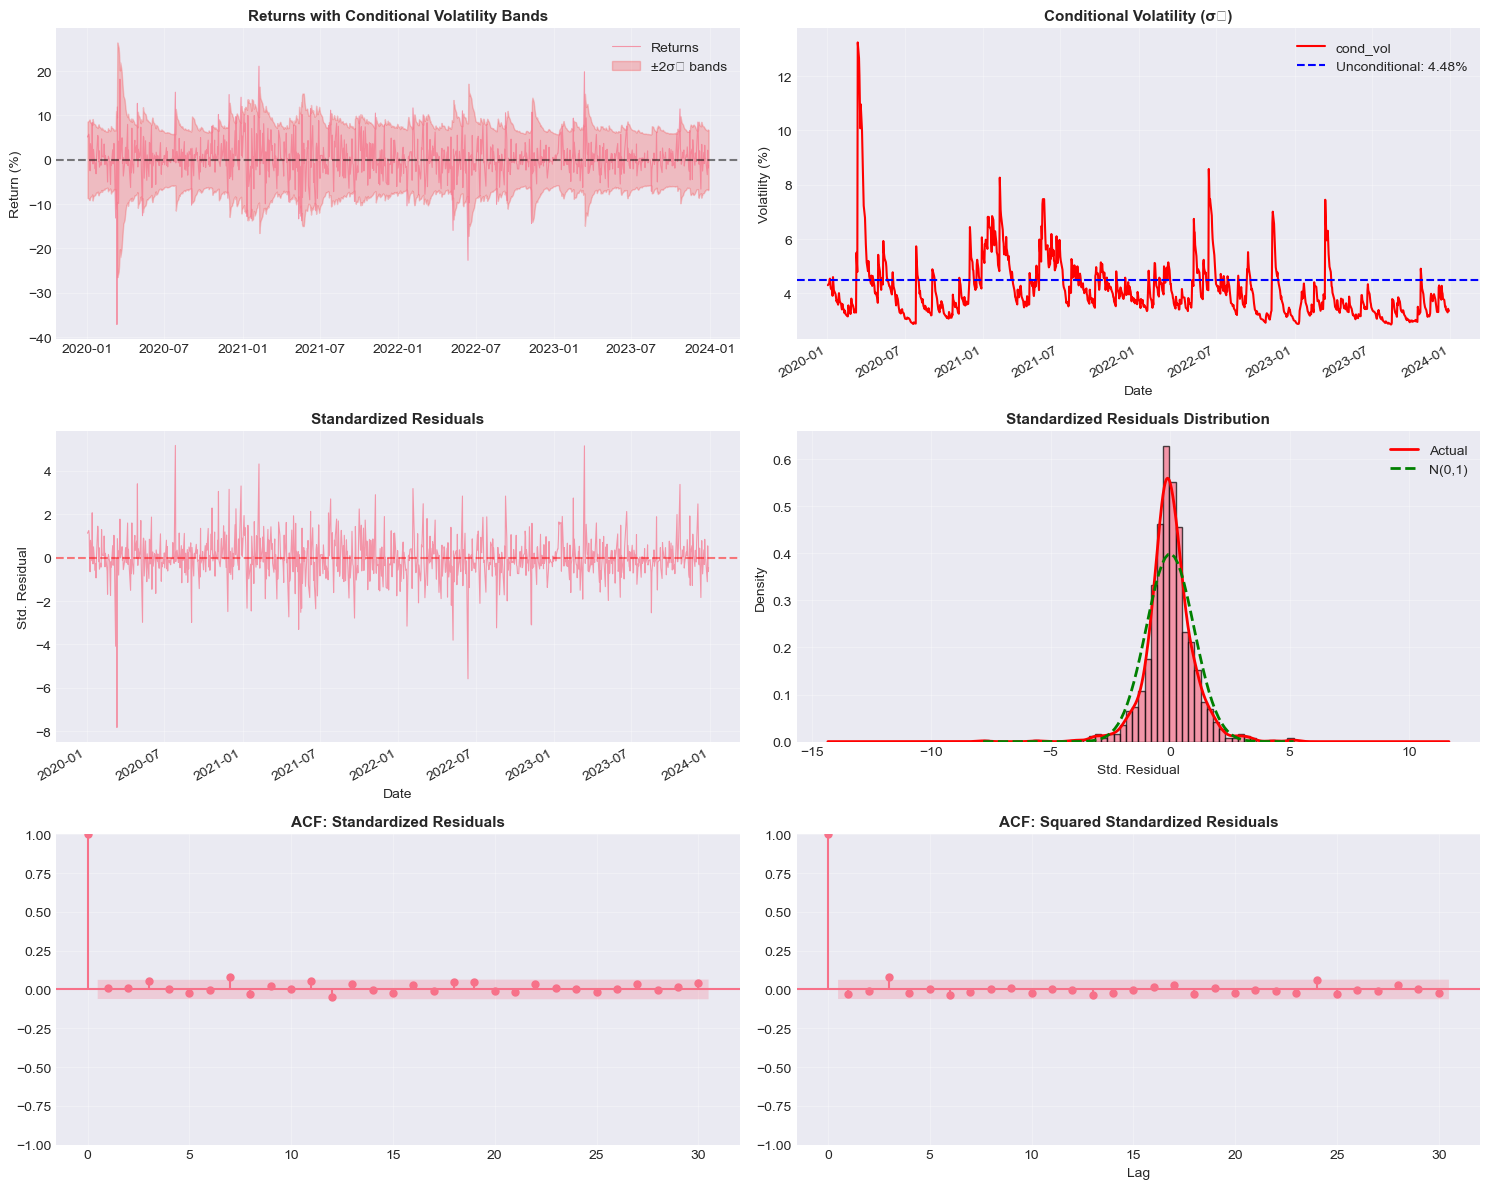


Model Diagnostics:
• Conditional volatility captures clustering
• Standardized residuals should be ~ N(0,1)
• No remaining autocorrelation in standardized residuals
• Reduced autocorrelation in squared standardized residuals


In [18]:
# Visualize fitted GARCH model
# Extract conditional volatility
cond_vol = garch_fitted.conditional_volatility
std_resid = garch_fitted.std_resid

fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Returns with conditional volatility bands
axes[0, 0].plot(sp_returns.index, sp_returns, linewidth=0.8, alpha=0.7, label='Returns')
axes[0, 0].fill_between(sp_returns.index, -2*cond_vol, 2*cond_vol, 
                        alpha=0.2, color='red', label='±2σₜ bands')
axes[0, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0, 0].set_title('Returns with Conditional Volatility Bands', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Return (%)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Conditional volatility
cond_vol.plot(ax=axes[0, 1], linewidth=1.5, color='red')
axes[0, 1].axhline(y=uncond_vol, color='blue', linestyle='--', 
                   label=f'Unconditional: {uncond_vol:.2f}%')
axes[0, 1].set_title('Conditional Volatility (σₜ)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Volatility (%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Standardized residuals
std_resid.plot(ax=axes[1, 0], linewidth=0.8, alpha=0.7)
axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1, 0].set_title('Standardized Residuals', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Std. Residual')
axes[1, 0].grid(True, alpha=0.3)

# Standardized residuals distribution
std_resid.hist(ax=axes[1, 1], bins=50, density=True, alpha=0.7, edgecolor='black')
std_resid.plot.kde(ax=axes[1, 1], color='red', linewidth=2, label='Actual')
x = np.linspace(std_resid.min(), std_resid.max(), 100)
axes[1, 1].plot(x, stats.norm.pdf(x, 0, 1), 'g--', linewidth=2, label='N(0,1)')
axes[1, 1].set_title('Standardized Residuals Distribution', fontsize=11, fontweight='bold')
axes[1, 1].set_xlabel('Std. Residual')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# ACF of standardized residuals
plot_acf(std_resid, lags=30, ax=axes[2, 0], alpha=0.05)
axes[2, 0].set_title('ACF: Standardized Residuals', fontsize=11, fontweight='bold')
axes[2, 0].grid(True, alpha=0.3)

# ACF of squared standardized residuals
plot_acf(std_resid**2, lags=30, ax=axes[2, 1], alpha=0.05)
axes[2, 1].set_title('ACF: Squared Standardized Residuals', fontsize=11, fontweight='bold')
axes[2, 1].set_xlabel('Lag')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nModel Diagnostics:")
print("• Conditional volatility captures clustering")
print("• Standardized residuals should be ~ N(0,1)")
print("• No remaining autocorrelation in standardized residuals")
print("• Reduced autocorrelation in squared standardized residuals")

In [19]:
# Test standardized residuals
print("\n" + "="*60)
print("Diagnostic Tests on Standardized Residuals")
print("="*60)

# Normality test
jb_stat, jb_pval = stats.jarque_bera(std_resid)
print(f"\nJarque-Bera Test (H0: Normal):")
print(f"  Statistic: {jb_stat:.2f}")
print(f"  P-value: {jb_pval:.4f}")
if jb_pval < 0.05:
    print(f"  ✗ Still reject normality (may need Student-t)")

# Ljung-Box on standardized residuals
lb_std = acorr_ljungbox(std_resid, lags=[10, 20], return_df=True)
print(f"\nLjung-Box Test on Standardized Residuals:")
print(lb_std)
if lb_std['lb_pvalue'].iloc[0] > 0.05:
    print(f"  ✓ No autocorrelation remaining")

# Ljung-Box on squared standardized residuals
lb_sq = acorr_ljungbox(std_resid**2, lags=[10, 20], return_df=True)
print(f"\nLjung-Box Test on Squared Standardized Residuals:")
print(lb_sq)
if lb_sq['lb_pvalue'].iloc[0] > 0.05:
    print(f"  ✓ GARCH successfully removed volatility clustering")
else:
    print(f"  ⚠ Some volatility clustering remains")


Diagnostic Tests on Standardized Residuals

Jarque-Bera Test (H0: Normal):
  Statistic: 2142.90
  P-value: 0.0000
  ✗ Still reject normality (may need Student-t)

Ljung-Box Test on Standardized Residuals:
    lb_stat  lb_pvalue
10  11.1064     0.3493
20  24.0716     0.2393
  ✓ No autocorrelation remaining

Ljung-Box Test on Squared Standardized Residuals:
    lb_stat  lb_pvalue
10  10.3610     0.4094
20  15.2613     0.7613
  ✓ GARCH successfully removed volatility clustering


## 4. Volatility Forecasting

### 4.1 One-Step-Ahead Forecast

For GARCH(1,1):
$$\hat{\sigma}_{t+1|t}^2 = \omega + \alpha \epsilon_t^2 + \beta \sigma_t^2$$

**Known at time t**: $\epsilon_t$ and $\sigma_t^2$

### 4.2 Multi-Step-Ahead Forecasts

For h-step ahead:
$$\hat{\sigma}_{t+h|t}^2 = E[\sigma_{t+h}^2 | \mathcal{F}_t]$$

**GARCH(1,1) h-step forecast**:
$$\hat{\sigma}_{t+h|t}^2 = \bar{\sigma}^2 + (\alpha + \beta)^h (\sigma_{t+1|t}^2 - \bar{\sigma}^2)$$

where $\bar{\sigma}^2 = \frac{\omega}{1-\alpha-\beta}$ is unconditional variance.

**Properties**:
- Forecasts converge to unconditional variance
- Rate of convergence: $(\alpha + \beta)^h$
- High persistence → slow convergence

### 4.3 Forecast Evaluation

Common metrics:
- **MSE**: $\frac{1}{T}\sum (\sigma_t^2 - \hat{\sigma}_t^2)^2$
- **QLIKE**: $\frac{1}{T}\sum \left(\frac{\sigma_t^2}{\hat{\sigma}_t^2} - \log\frac{\sigma_t^2}{\hat{\sigma}_t^2} - 1\right)$
- **Realized volatility**: Use high-frequency data as proxy


Volatility Forecasting


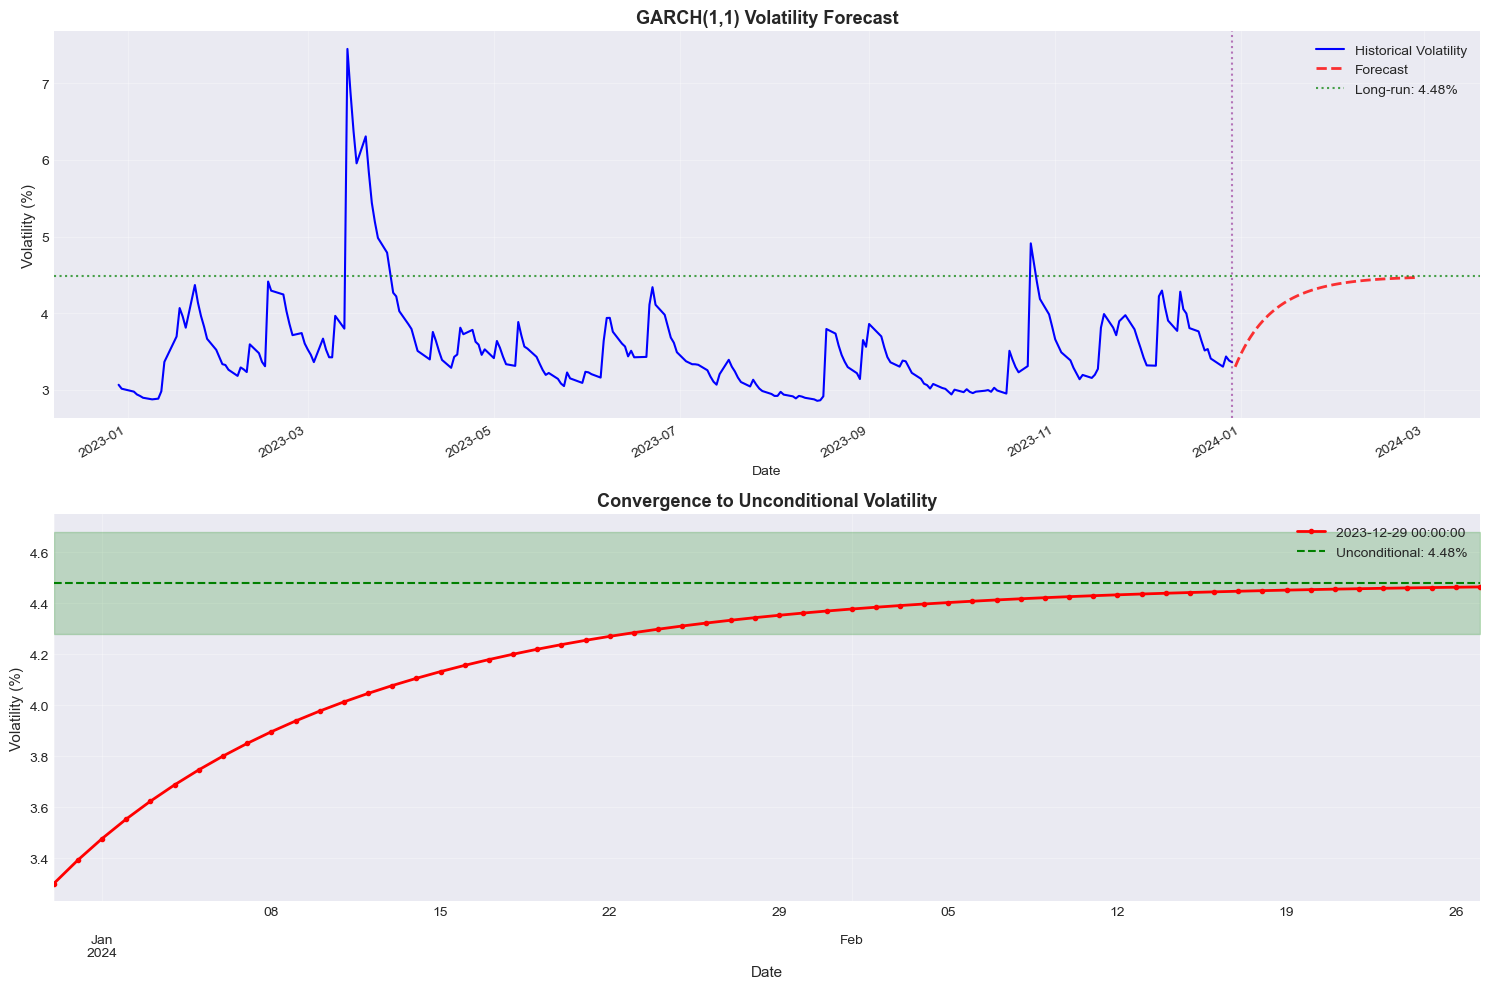


Forecast Summary:
  1-day ahead: 3.3000%
  5-day ahead: 3.6234%
  20-day ahead: 4.1999%
  60-day ahead: 4.4639%
  Long-run: 4.4806%

  Remaining deviation after 60 days: 1.4%


In [21]:
# Generate volatility forecasts
print("\n" + "="*60)
print("Volatility Forecasting")
print("="*60)

# Generate forecast
horizon = 60  # 60 days
forecast = garch_fitted.forecast(horizon=horizon)
forecast_var = forecast.variance.iloc[-1]
forecast_vol = np.sqrt(forecast_var)

# Create forecast dates
last_date = sp_returns.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), 
                               periods=horizon, freq='D')
forecast_vol.index = forecast_dates

# Plot forecasts
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Historical volatility with forecast
cond_vol.iloc[-252:].plot(ax=axes[0], linewidth=1.5, color='blue', 
                          label='Historical Volatility')
forecast_vol.plot(ax=axes[0], linewidth=2, color='red', style='--',
                 label='Forecast', alpha=0.8)
axes[0].axhline(y=uncond_vol, color='green', linestyle=':', 
               label=f'Long-run: {uncond_vol:.2f}%', alpha=0.7)
axes[0].axvline(x=last_date, color='purple', linestyle=':', alpha=0.5)
axes[0].set_title('GARCH(1,1) Volatility Forecast', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Volatility (%)', fontsize=11)
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Forecast convergence to unconditional
forecast_vol.plot(ax=axes[1], linewidth=2, color='red', marker='o', markersize=3)
axes[1].axhline(y=uncond_vol, color='green', linestyle='--', 
               label=f'Unconditional: {uncond_vol:.2f}%')
axes[1].fill_between(forecast_dates, uncond_vol - 0.2, uncond_vol + 0.2,
                     alpha=0.2, color='green')
axes[1].set_title('Convergence to Unconditional Volatility', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Volatility (%)', fontsize=11)
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nForecast Summary:")
print(f"  1-day ahead: {forecast_vol.iloc[0]:.4f}%")
print(f"  5-day ahead: {forecast_vol.iloc[4]:.4f}%")
print(f"  20-day ahead: {forecast_vol.iloc[19]:.4f}%")
print(f"  60-day ahead: {forecast_vol.iloc[59]:.4f}%")
print(f"  Long-run: {uncond_vol:.4f}%")

# Calculate convergence rate
conv_rate = (forecast_vol.iloc[-1] - uncond_vol) / (forecast_vol.iloc[0] - uncond_vol)
print(f"\n  Remaining deviation after 60 days: {conv_rate:.1%}")

## 5. Extensions: EGARCH and GJR-GARCH

### 5.1 Asymmetric Volatility (Leverage Effect)

**Empirical observation**: Negative returns → larger volatility increase than positive returns

**Black (1976) leverage hypothesis**: 
- Stock price decline → higher leverage → higher risk
- Alternatively: Volatility feedback effect

Standard GARCH(1,1) **cannot** model this asymmetry.

### 5.2 GJR-GARCH Model

Glosten, Jagannathan, and Runkle (1993):

$$\sigma_t^2 = \omega + (\alpha + \gamma I_{t-1})\epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$

where $I_{t-1} = 1$ if $\epsilon_{t-1} < 0$ (negative shock), 0 otherwise.

**Interpretation**:
- Positive shock: Impact = $\alpha$
- Negative shock: Impact = $\alpha + \gamma$
- $\gamma > 0$: Negative shocks have larger effect (leverage)

### 5.3 EGARCH Model

Nelson (1991) - Exponential GARCH:

$$\log(\sigma_t^2) = \omega + \alpha \left|\frac{\epsilon_{t-1}}{\sigma_{t-1}}\right| + \gamma \frac{\epsilon_{t-1}}{\sigma_{t-1}} + \beta \log(\sigma_{t-1}^2)$$

**Advantages**:
- No parameter constraints (log ensures $\sigma_t^2 > 0$)
- Captures leverage effect if $\gamma < 0$
- Exponential form allows larger movements

**Interpretation**:
- $\gamma < 0$: Negative shocks increase volatility more
- $|\gamma|$: Magnitude of asymmetry

In [25]:
# Compare GARCH, GJR-GARCH, and EGARCH
print("\n" + "="*60)
print("Comparing Volatility Models")
print("="*60)

# Fit different models
models = {}

# Standard GARCH(1,1)
garch = arch_model(sp_returns, vol='GARCH', p=1, q=1, dist='normal')
models['GARCH'] = garch.fit(disp='off')

# GJR-GARCH(1,1)
gjr = arch_model(sp_returns, vol='GARCH', p=1, o=1, q=1, dist='normal')
models['GJR-GARCH'] = gjr.fit(disp='off')

# EGARCH(1,1)
egarch = arch_model(sp_returns, vol='EGARCH', p=1, q=1, dist='normal')
models['EGARCH'] = egarch.fit(disp='off')

# Compare models
comparison = pd.DataFrame({
    'GARCH': [models['GARCH'].loglikelihood, 
              models['GARCH'].aic, 
              models['GARCH'].bic],
    'GJR-GARCH': [models['GJR-GARCH'].loglikelihood, 
                  models['GJR-GARCH'].aic, 
                  models['GJR-GARCH'].bic],
    'EGARCH': [models['EGARCH'].loglikelihood, 
               models['EGARCH'].aic, 
               models['EGARCH'].bic]
}, index=['Log-Likelihood', 'AIC', 'BIC'])

print("\nModel Comparison:")
print(comparison.round(2))

# Check for leverage effect
print("\n" + "="*60)
print("Leverage Effect Test")
print("="*60)

if 'gamma[1]' in models['GJR-GARCH'].params:
    gamma_gjr = models['GJR-GARCH'].params['gamma[1]']
    gamma_pval = models['GJR-GARCH'].pvalues['gamma[1]']
    print(f"\nGJR-GARCH Leverage Parameter (γ):")
    print(f"  Estimate: {gamma_gjr:.4f}")
    print(f"  P-value: {gamma_pval:.4f}")
    if gamma_pval < 0.05 and gamma_gjr > 0:
        print(f"  ✓ Significant leverage effect detected")
        print(f"  Negative shocks increase volatility {(1 + gamma_gjr):.2f}x more")

if 'gamma[1]' in models['EGARCH'].params:
    gamma_egarch = models['EGARCH'].params['gamma[1]']
    gamma_pval_e = models['EGARCH'].pvalues['gamma[1]']
    print(f"\nEGARCH Asymmetry Parameter (γ):")
    print(f"  Estimate: {gamma_egarch:.4f}")
    print(f"  P-value: {gamma_pval_e:.4f}")
    if gamma_pval_e < 0.05 and gamma_egarch < 0:
        print(f"  ✓ Significant asymmetry detected")
        print(f"  Negative shocks have larger impact on log-volatility")


Comparing Volatility Models

Model Comparison:
                  GARCH  GJR-GARCH   EGARCH
Log-Likelihood -2829.58   -2822.07 -2832.31
AIC             5667.17    5654.14  5672.61
BIC             5686.82    5678.71  5692.26

Leverage Effect Test

GJR-GARCH Leverage Parameter (γ):
  Estimate: 0.1072
  P-value: 0.2279


In [32]:
models.get('EGARCH')

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                  SP500   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -2832.31
Distribution:                  Normal   AIC:                           5672.61
Method:            Maximum Likelihood   BIC:                           5692.26
                                        No. Observations:                 1005
Date:                Mon, Jan 19 2026   Df Residuals:                     1004
Time:                        11:58:16   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.3558      0.136      2.623  8.703e-03 [8.999e-0

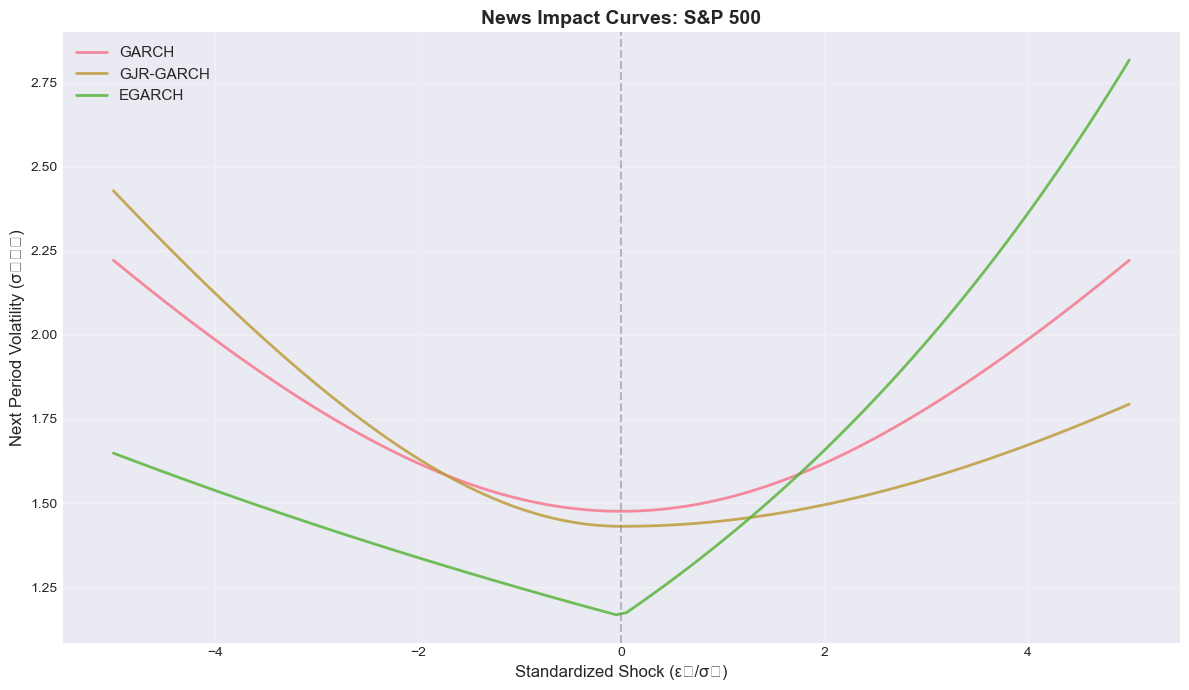


News Impact Curve Interpretation:
• GARCH: Symmetric - same response to positive/negative shocks
• GJR-GARCH: Asymmetric - steeper for negative shocks
• EGARCH: Asymmetric - can be highly asymmetric
• Negative shocks typically increase volatility more (leverage)


In [34]:
# Visualize news impact curves
def plot_news_impact_curve(models, title='News Impact Curve'):
    """
    Plot news impact curves for different GARCH models.
    """
    # Range of shocks
    shocks = np.linspace(-5, 5, 100)
    
    # Current volatility (use unconditional)
    sigma_current = 1.0  # Standardized
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    for name, model in models.items():
        params = model.params
        
        if name == 'GARCH':
            omega = params['omega']
            alpha = params['alpha[1]']
            beta = params['beta[1]']
            sigma_next = np.sqrt(omega + alpha * shocks**2 + beta * sigma_current**2)
        
        elif name == 'GJR-GARCH':
            omega = params['omega']
            alpha = params['alpha[1]']
            gamma = params.get('gamma[1]', 0)
            beta = params['beta[1]']
            indicator = (shocks < 0).astype(float)
            sigma_next = np.sqrt(omega + (alpha + gamma * indicator) * shocks**2 + 
                               beta * sigma_current**2)
        
        elif name == 'EGARCH':
            omega = params['omega']
            alpha = params['alpha[1]']
            #gamma = params['gamma[1]']
            beta = params['beta[1]']
            log_sigma_next = (omega + alpha * np.abs(shocks/sigma_current) + 
                            gamma * (shocks/sigma_current) + beta * np.log(sigma_current**2))
            sigma_next = np.exp(log_sigma_next/2)
        
        ax.plot(shocks, sigma_next, linewidth=2, label=name, alpha=0.8)
    
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Standardized Shock (εₜ/σₜ)', fontsize=12)
    ax.set_ylabel('Next Period Volatility (σₜ₊₁)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot news impact curves
plot_news_impact_curve(models, 'News Impact Curves: S&P 500')

print("\nNews Impact Curve Interpretation:")
print("• GARCH: Symmetric - same response to positive/negative shocks")
print("• GJR-GARCH: Asymmetric - steeper for negative shocks")
print("• EGARCH: Asymmetric - can be highly asymmetric")
print("• Negative shocks typically increase volatility more (leverage)")

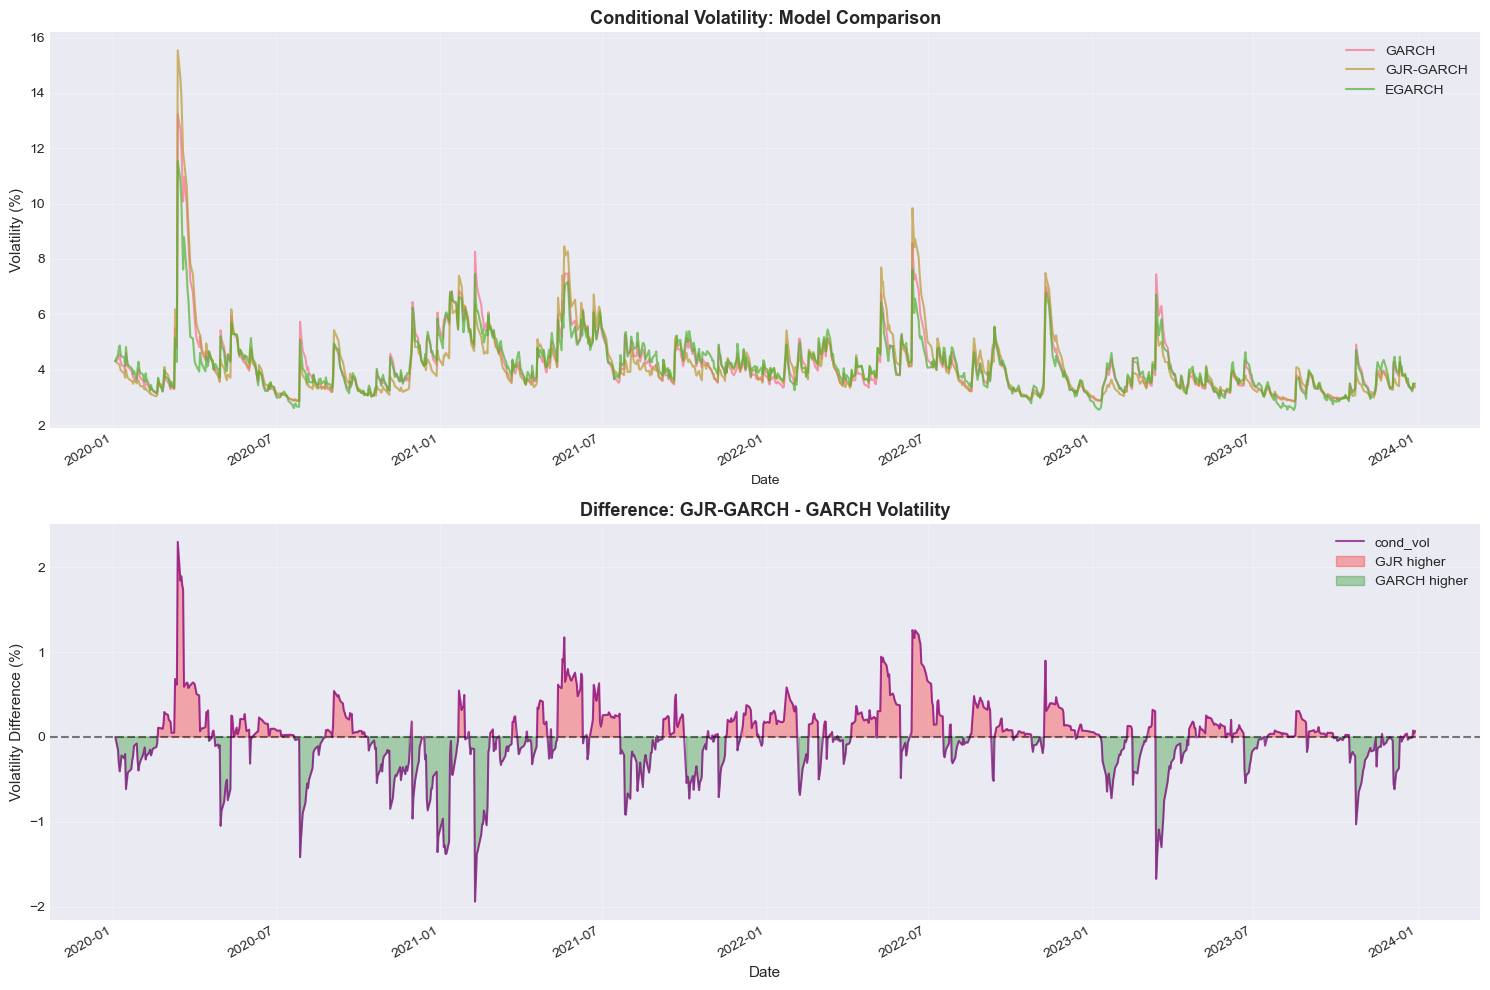


Key Insights:
• Models produce similar volatility estimates overall
• GJR-GARCH typically higher after negative shocks
• Differences most pronounced during volatile periods
• Asymmetric models better capture leverage effect


In [36]:
# Compare conditional volatilities
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Conditional volatilities
for name, model in models.items():
    cond_vol = model.conditional_volatility
    cond_vol.plot(ax=axes[0], linewidth=1.5, label=name, alpha=0.7)

axes[0].set_title('Conditional Volatility: Model Comparison', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Volatility (%)', fontsize=11)
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Difference between GJR-GARCH and GARCH
vol_diff = models['GJR-GARCH'].conditional_volatility - models['GARCH'].conditional_volatility
vol_diff.plot(ax=axes[1], linewidth=1.5, color='purple', alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].fill_between(vol_diff.index, 0, vol_diff, where=(vol_diff > 0),
                     color='red', alpha=0.3, label='GJR higher')
axes[1].fill_between(vol_diff.index, 0, vol_diff, where=(vol_diff <= 0),
                     color='green', alpha=0.3, label='GARCH higher')
axes[1].set_title('Difference: GJR-GARCH - GARCH Volatility', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Volatility Difference (%)', fontsize=11)
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("• Models produce similar volatility estimates overall")
print("• GJR-GARCH typically higher after negative shocks")
print("• Differences most pronounced during volatile periods")
print("• Asymmetric models better capture leverage effect")

## 6. Student-t Distribution

### 6.1 Fat Tails in Returns

Even after GARCH modeling, standardized residuals often show excess kurtosis.

**Solution**: Use Student-t distribution instead of Normal.

### 6.2 GARCH with Student-t

$$\epsilon_t = \sigma_t z_t, \quad z_t \sim t(\nu)$$

where $\nu$ is degrees of freedom parameter.

**Properties**:
- $\nu > 2$: Variance exists
- $\nu \to \infty$: Converges to Normal
- Lower $\nu$: Fatter tails
- Typical for stocks: $\nu \approx 5-15$

### 6.3 Advantages

- Better fit to actual return distribution
- More accurate VaR and risk measures
- Accounts for extreme events
- Slightly more parameters to estimate

In [39]:
# Compare Normal vs Student-t
print("\n" + "="*60)
print("GARCH with Different Error Distributions")
print("="*60)

# Fit GARCH with Normal
garch_normal = arch_model(sp_returns, vol='GARCH', p=1, q=1, dist='normal')
fit_normal = garch_normal.fit(disp='off')

# Fit GARCH with Student-t
garch_t = arch_model(sp_returns, vol='GARCH', p=1, q=1, dist='t')
fit_t = garch_t.fit(disp='off')

# Compare
print("\nModel Comparison:")
comparison_dist = pd.DataFrame({
    'Normal': [fit_normal.loglikelihood, fit_normal.aic, fit_normal.bic],
    'Student-t': [fit_t.loglikelihood, fit_t.aic, fit_t.bic]
}, index=['Log-Likelihood', 'AIC', 'BIC'])
print(comparison_dist.round(2))

# Extract degrees of freedom
nu = fit_t.params['nu']
print(f"\nStudent-t degrees of freedom: {nu:.2f}")
if nu < 10:
    print(f"  → Very fat tails (ν < 10)")
elif nu < 30:
    print(f"  → Moderate fat tails")
else:
    print(f"  → Close to Normal")

# Likelihood ratio test
lr_stat = 2 * (fit_t.loglikelihood - fit_normal.loglikelihood)
lr_pval = 1 - stats.chi2.cdf(lr_stat, df=1)
print(f"\nLikelihood Ratio Test:")
print(f"  Statistic: {lr_stat:.2f}")
print(f"  P-value: {lr_pval:.4f}")
if lr_pval < 0.05:
    print(f"  ✓ Student-t provides significantly better fit")


GARCH with Different Error Distributions

Model Comparison:
                 Normal  Student-t
Log-Likelihood -2829.58   -2708.90
AIC             5667.17    5427.80
BIC             5686.82    5452.37

Student-t degrees of freedom: 3.00
  → Very fat tails (ν < 10)

Likelihood Ratio Test:
  Statistic: 241.37
  P-value: 0.0000
  ✓ Student-t provides significantly better fit


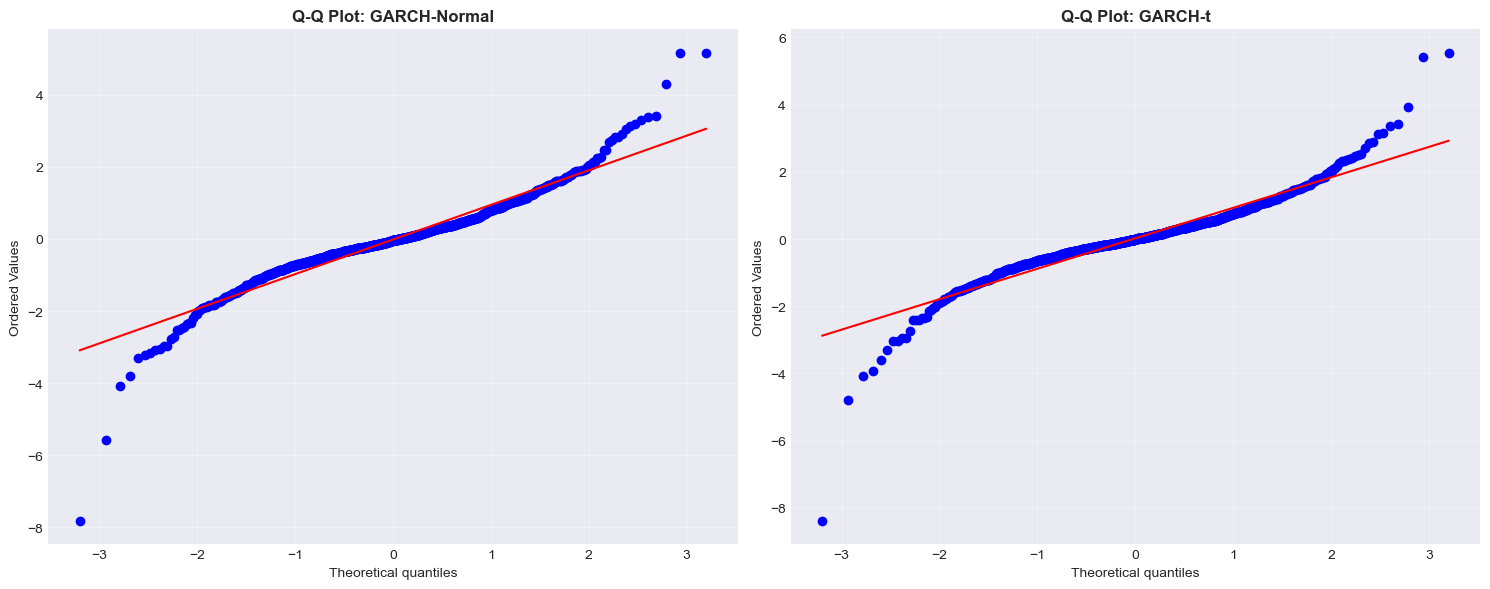

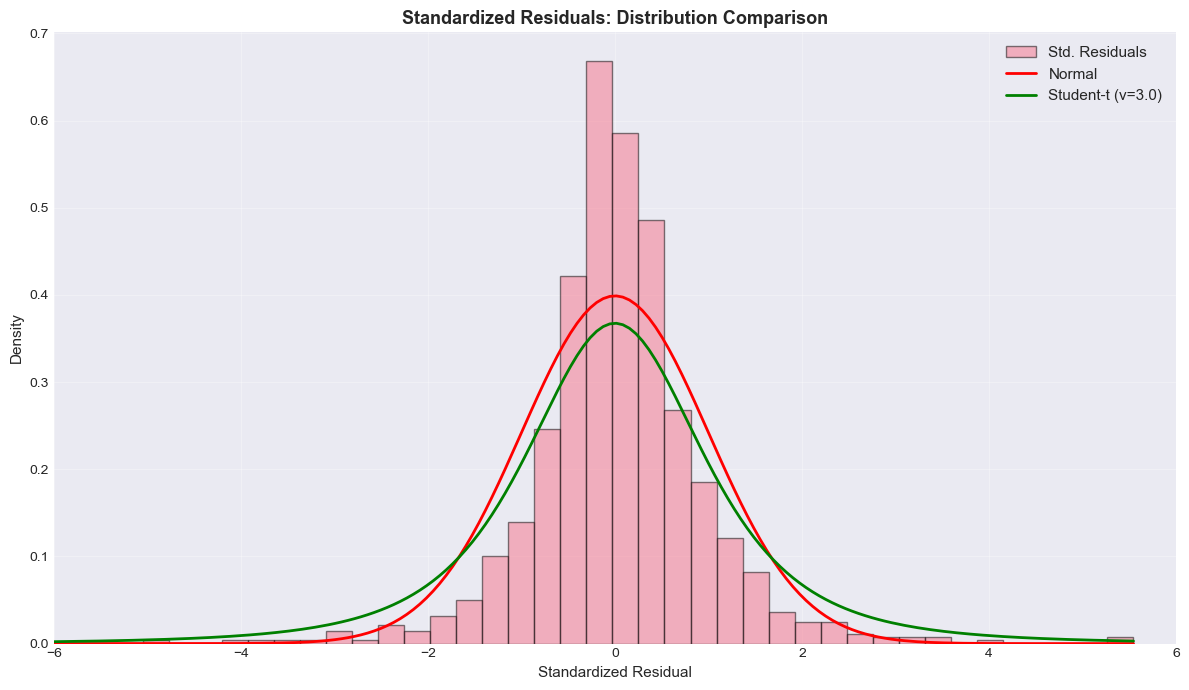


Key Findings:
• Student-t better fits the tails of the distribution
• Normal distribution underestimates tail risk
• GARCH-t recommended for financial applications
• Important for VaR and risk management


In [41]:
# Compare standardized residual distributions
std_resid_normal = fit_normal.std_resid
std_resid_t = fit_t.std_resid

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Q-Q plots
stats.probplot(std_resid_normal, dist="norm", plot=axes[0])
axes[0].set_title('Q-Q Plot: GARCH-Normal', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

stats.probplot(std_resid_t, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot: GARCH-t', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Distribution comparison
fig, ax = plt.subplots(figsize=(12, 7))

# Histogram
std_resid_t.hist(bins=50, density=True, alpha=0.5, edgecolor='black', label='Std. Residuals')

# Overlay distributions
x = np.linspace(std_resid_t.min(), std_resid_t.max(), 200)
ax.plot(x, stats.norm.pdf(x, 0, 1), 'r-', linewidth=2, label='Normal')
ax.plot(x, stats.t.pdf(x, nu), 'g-', linewidth=2, label=f'Student-t (ν={nu:.1f})')

ax.set_xlabel('Standardized Residual', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title('Standardized Residuals: Distribution Comparison', fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.set_xlim(-6, 6)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Findings:")
print("• Student-t better fits the tails of the distribution")
print("• Normal distribution underestimates tail risk")
print("• GARCH-t recommended for financial applications")
print("• Important for VaR and risk management")

## 7. Summary and Best Practices

### 7.1 GARCH Modeling Workflow

**Step 1: Test for ARCH Effects**
- Ljung-Box on squared returns
- ARCH LM test
- Visual inspection

**Step 2: Model Selection**
- Start with GARCH(1,1)
- Test for leverage (GJR, EGARCH)
- Consider Student-t distribution

**Step 3: Estimation**
- Use Maximum Likelihood
- Check convergence
- Verify parameter constraints

**Step 4: Diagnostics**
- Examine standardized residuals
- Test for remaining ARCH
- Check distribution assumptions

**Step 5: Forecasting**
- Generate volatility forecasts
- Calculate VaR if needed
- Monitor forecast performance

### 7.2 Model Selection Guidelines

| Application | Recommended Model | Reason |
|-------------|------------------|--------|
| Stock indices | GJR-GARCH(1,1)-t | Leverage effect, fat tails |
| Exchange rates | GARCH(1,1)-t | No leverage, fat tails |
| Commodities | GARCH(1,1)-Normal | Less fat tails |
| Crypto | EGARCH(1,1)-t | Extreme volatility |

### 7.3 Key Takeaways

**ARCH/GARCH Models**:
- Model time-varying conditional variance
- Capture volatility clustering
- GARCH(1,1) works remarkably well
- High persistence typical in financial data

**Extensions**:
- GJR-GARCH for leverage effects
- EGARCH for asymmetry and no constraints
- Student-t for fat tails
- Combination usually best for stocks

**Applications**:
- Volatility forecasting
- Risk management (VaR, CVaR)
- Option pricing
- Portfolio optimization

**Limitations**:
- Assumes stationary parameters
- Cannot handle structural breaks
- Single equation models only
- See multivariate GARCH (Session 7)

### 7.4 Next Session Preview

In **Session 7**, we will cover:
- Long memory in volatility (FIGARCH)
- Multivariate GARCH models (BEKK, DCC)
- Volatility spillovers
- Realized volatility
- Advanced applications

## 8. Exercises

### Exercise 1: Stylized Facts
Download daily returns for a stock of your choice (3+ years):
1. Calculate and interpret basic statistics
2. Test for normality
3. Test for autocorrelation in returns and squared returns
4. Perform ARCH LM test
5. Conclude whether GARCH is appropriate

### Exercise 2: GARCH Estimation
For S&P 500 or another index:
1. Fit GARCH(1,1) with normal errors
2. Interpret α, β, and persistence
3. Calculate unconditional volatility
4. Compute half-life of shocks
5. Check standardized residuals for white noise

### Exercise 3: Model Comparison
Using the same data:
1. Fit ARCH(1), GARCH(1,1), GJR-GARCH(1,1), EGARCH(1,1)
2. Compare using AIC and BIC
3. Test for leverage effect significance
4. Which model fits best?
5. Generate and compare volatility forecasts

### Exercise 4: Distribution Choice
For Bitcoin or high-volatility asset:
1. Fit GARCH(1,1) with Normal, Student-t, and Skewed-t
2. Compare log-likelihoods
3. Examine Q-Q plots
4. Which distribution fits best?
5. How does this affect VaR estimates?

### Exercise 5: Forecasting Application
Build a volatility forecasting system:
1. Estimate GARCH on training data (80%)
2. Generate 1-day ahead forecasts for test period
3. Use realized volatility as proxy for true volatility
4. Calculate forecast RMSE and QLIKE
5. Compare with naive (moving average) forecasts

In [ ]:
# Space for your solutions to exercises

# Exercise 1:
# Your code here

# Exercise 2:
# Your code here

# Exercise 3:
# Your code here

# Exercise 4:
# Your code here

# Exercise 5:
# Your code here

## References and Further Reading

### Seminal Papers:
1. Engle, R.F. (1982). Autoregressive conditional heteroscedasticity with estimates of the variance of United Kingdom inflation. *Econometrica*, 50(4), 987-1007.
2. Bollerslev, T. (1986). Generalized autoregressive conditional heteroskedasticity. *Journal of Econometrics*, 31(3), 307-327.
3. Nelson, D.B. (1991). Conditional heteroskedasticity in asset returns: A new approach. *Econometrica*, 59(2), 347-370.
4. Glosten, L.R., Jagannathan, R., & Runkle, D.E. (1993). On the relation between the expected value and the volatility of the nominal excess return on stocks. *Journal of Finance*, 48(5), 1779-1801.

### Textbooks:
1. Tsay, R.S. (2010). *Analysis of Financial Time Series* (3rd ed.). Wiley.
2. Taylor, S.J. (2008). *Modelling Financial Time Series* (2nd ed.). World Scientific.
3. Francq, C., & Zakoïan, J.M. (2019). *GARCH Models: Structure, Statistical Inference and Financial Applications* (2nd ed.). Wiley.
4. Engle, R.F. (Ed.). (1995). *ARCH: Selected Readings*. Oxford University Press.

### Software and Tools:
1. ARCH package: https://arch.readthedocs.io/
2. Statsmodels: https://www.statsmodels.org/
3. rugarch (R): https://cran.r-project.org/package=rugarch

### Online Resources:
1. Kevin Sheppard's Financial Econometrics Notes: https://www.kevinsheppard.com/
2. Quantitative Risk Management: https://qrm.readthedocs.io/

---

**Instructor Contact**: [Mathis J.F. Mourey. mjfmourey@hhs.nl]

**Office Hours**: [Mon-Fri 9am-5pm]